In [6]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import akshare as ak
from utils.utils import normalize, func_list
import warnings
warnings.filterwarnings('ignore')


In [7]:
FILE_PATH = '../data/raw/macro_data.xlsx'
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
EXPAND=365

In [8]:
def get_macro_data(file_path, start_date, end_date, expand=None):
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    if expand:
        start_date = start_date - pd.Timedelta(expand, 'd')
    df = pd.read_excel(file_path)
    print(f'Features: {list(df.columns[1:])}')
    df.columns = ['date'] + [f'mf{i+1}' for i in range(df.shape[1] - 1)]
    df['date'] = pd.to_datetime(df['date'])

    df_trade_date = ak.tool_trade_date_hist_sina()
    trade_date_list = pd.to_datetime(df_trade_date['trade_date']).values
    df = df[df['date'].isin(trade_date_list)]
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    df = df.sort_values(by='date').reset_index(drop=True)
    num_null = df.isnull().sum().sum()
    if num_null == 0:
        print('There is no NAs.')
    elif num_null > 0:
        print(f'There are {num_null} NAs.')
        print('Filling NAs with forward method.')
        df = df.fillna(method='ffill')
    
    return df

In [9]:
df_macro = get_macro_data(FILE_PATH, START_DATE, END_DATE, expand=EXPAND)
print('Unnormalized raw macro data.')
df_macro.head()

Features: ['中间价:美元兑人民币', 'SHIBOR:隔夜', 'SHIBOR:1年', '上证综合指数', '沪深300指数', '成交量:上证综合指数', '成交量:沪深300', '上证国债指数', '上证企债指数']
There are 1 NAs.
Filling NAs with forward method.
Unnormalized raw macro data.


,date,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9
0,2009-01-05,6.8367,0.9086,2.3003,1880.716,1882.959,67.136715,48.187020,121.217,132.829
1,2009-01-06,6.8384,0.8967,2.2768,1937.145,1942.795,99.066756,70.974097,121.180,132.922
2,2009-01-07,6.8389,0.8894,2.2512,1924.012,1931.178,92.360086,59.702167,121.120,132.974
3,2009-01-08,6.8375,0.8829,2.2293,1878.181,1887.991,80.374000,53.446490,121.192,133.220
4,2009-01-09,6.8363,0.8363,2.2003,1904.861,1918.365,71.224779,47.407216,121.221,133.357


In [10]:
def extend_macro_data(df, func_list=[]):
    '''
    construct features based on basic features
    include: pctchange + func_list
    drop raw absolute-valued features
    '''
    df = df.copy()
    features = df.drop(columns=['date']).columns
    for func in func_list:
        df_tmp = df_macro[features].transform(func)
        df_tmp.columns = [col + func.__name__ for col in features]
        df = pd.concat([df, df_tmp], axis=1)

    return df.drop(columns = features)

In [11]:
df_extended_macro = extend_macro_data(df_macro, func_list)
df_extended_macro = df_extended_macro[(df_extended_macro['date'] >= START_DATE) &
                                      (df_extended_macro['date'] <= END_DATE)]

df_extended_macro = df_extended_macro.reset_index(drop=True)
print('Unnormalized extended macro data.')
df_extended_macro.head()

Unnormalized extended macro data.


,date,mf1roc1,mf2roc1,mf3roc1,mf4roc1,mf5roc1,mf6roc1,mf7roc1,mf8roc1,mf9roc1,...,mf9std,mf1slope,mf2slope,mf3slope,mf4slope,mf5slope,mf6slope,mf7slope,mf8slope,mf9slope
0,2010-01-04,-0.001465,-2.546438,0.000000,-1.018541,-1.131392,-6.069731,-4.535997,-0.009808,0.225392,...,0.264486,4.207792e-05,-0.003677,0.000562,-5.559790,-8.042418,-2.173080,-1.478505,-0.005883,0.040619
1,2010-01-05,-0.004394,-0.223714,-0.004444,1.184397,0.814912,15.228373,29.815793,-0.043323,-0.115805,...,0.277344,2.623377e-05,-0.003635,0.000503,-3.259919,-5.580322,-0.438414,-0.298041,-0.008582,0.043482
2,2010-01-06,-0.001465,0.295964,0.000000,-0.851995,-0.626003,-1.953519,-8.549757,0.026986,0.046376,...,0.292250,1.688312e-05,-0.003538,0.000431,-1.065753,-2.942779,0.294218,0.236965,-0.009703,0.046887
3,2010-01-07,-0.001465,-3.451668,0.222212,-1.887982,-1.984089,4.044793,2.391790,-0.004905,0.023177,...,0.302204,4.935065e-06,-0.003885,0.000424,-0.071939,-1.692961,1.072726,0.694556,-0.011622,0.049010
4,2010-01-08,0.004394,-1.750486,0.190679,0.100884,0.249866,-23.532852,-24.343217,0.004906,0.084465,...,0.300723,-1.298701e-07,-0.004434,0.000466,0.282969,-1.125803,1.155104,0.695497,-0.013121,0.048779


In [12]:
df_extended_macro.iloc[:, 1:] = df_extended_macro.iloc[:, 1:].apply(normalize)
print('Normalized extended macro data.')
df_extended_macro.head()

Normalized extended macro data.


,date,mf1roc1,mf2roc1,mf3roc1,mf4roc1,mf5roc1,mf6roc1,mf7roc1,mf8roc1,mf9roc1,...,mf9std,mf1slope,mf2slope,mf3slope,mf4slope,mf5slope,mf6slope,mf7slope,mf8slope,mf9slope
0,2010-01-04,0.006069,-0.618298,-0.109049,-0.935985,-0.939400,-0.410068,-0.291687,-0.811746,2.288602,...,-0.230552,0.129274,-0.130752,0.037304,-0.669455,-0.802342,-0.624455,-0.635298,-1.496510,-0.085397
1,2010-01-05,-0.016688,-0.032575,-0.156174,1.012315,0.611278,0.785294,1.280289,-1.930444,-2.422263,...,-0.144733,0.122866,-0.129303,0.023146,-0.406500,-0.576957,-0.107638,-0.113447,-1.638354,0.004635
2,2010-01-06,0.006068,0.098473,-0.109049,-0.788690,-0.536742,-0.179045,-0.475361,0.416416,0.754828,...,-0.045246,0.119085,-0.125938,0.005825,-0.155631,-0.335511,0.110639,0.123064,-1.697262,0.111742
3,2010-01-07,0.006068,-0.846571,1.604754,-1.704927,-1.618769,0.157612,0.025337,-0.648098,0.017969,...,0.021190,0.114252,-0.137916,0.004103,-0.042004,-0.221101,0.342584,0.325353,-1.798151,0.178531
4,2010-01-08,0.051586,-0.417582,1.604754,0.054046,0.161090,-1.390191,-1.198087,-0.320622,1.964653,...,0.011307,0.112204,-0.156810,0.014157,-0.001426,-0.169182,0.367127,0.325769,-1.876922,0.171259


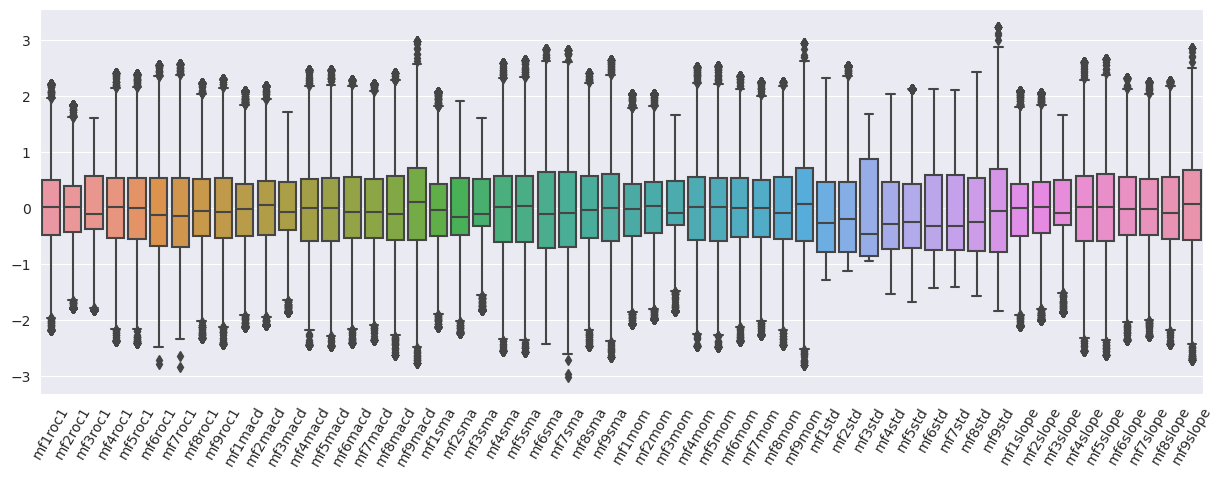

In [13]:
fig = plt.figure(figsize = (15, 5))
sns.boxplot(df_extended_macro)
plt.xticks(rotation=60)
plt.show()

In [16]:
df_extended_macro.isnull().sum().sum()

0

In [17]:
# df_extended_macro.to_csv('../data/processed/macro_data.csv', index=False)